In [94]:
#Импорт библиотек

import csv
import pandas as pd
import numpy as np
import math
import scipy.stats as st
import itertools as it
import numpy.matlib as nm
from sklearn import metrics
import sklearn.model_selection as ms
import sklearn.metrics as metrics
from statsmodels.miscmodels.ordinal_model import OrderedModel
from sklearn import linear_model
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [95]:
#Расчет Somers D

def somers_d(xx,yy,weight = None):
    
    '''
    xx - feature
    yy - target
    weight - weights
    '''
    
    if weight is None: weight = np.ones(len(xx))

    x = st.rankdata(xx)
    y = st.rankdata(yy)
    weight = np.array(weight)
    
    n2_const = sum(weight[:-1]*(sum(weight)-np.cumsum(weight[:-1])))
    K, y_adj = 0, 0

    for i in range(len(weight)-1):
        sign_arr_x = np.sign(x[i]-x[i+1:len(weight)])
        sign_arr_y = np.sign(y[i]-y[i+1:len(weight)])
        ww_arr = weight[i]*weight[i+1:]

        K += sum(ww_arr*sign_arr_x*sign_arr_y)
        y_adj += sum(ww_arr*(1 - abs(sign_arr_y*sign_arr_y)))
        
    return K/(n2_const-y_adj)

In [96]:
#Загрузка исходных данных

a = pd.read_excel(io='Data_for_loading_zadanie.xlsx',sheet_name='Data_for_loading');
a.head()

,Number_Project,DSU_BEN_norm,IRR_norm,DSCR_norm,LLCR_norm,IND_FACTOR_norm,REG_FACTOR_norm,Default_flag,Expert_rating
0,ПРОЕКТ-1,-1.451350,2.160415,0.673599,-0.113813,0.361433,0.772218,0,5
1,ПРОЕКТ-2,0.404153,1.834460,-0.691891,-0.205317,0.361433,0.772218,0,4
2,ПРОЕКТ-3,-0.521998,-0.811909,-0.651672,-0.362772,0.361433,0.772218,0,3
3,ПРОЕКТ-4,-1.060835,-1.134109,-0.337244,-0.350634,0.361433,0.772218,0,3
4,ПРОЕКТ-5,1.476043,1.544695,0.002757,2.996431,0.361433,-1.278154,0,2


In [97]:
a.info

<bound method DataFrame.info of    Number_Project  DSU_BEN_norm  IRR_norm  DSCR_norm  LLCR_norm  \
0        ПРОЕКТ-1     -1.451350  2.160415   0.673599  -0.113813   
1        ПРОЕКТ-2      0.404153  1.834460  -0.691891  -0.205317   
2        ПРОЕКТ-3     -0.521998 -0.811909  -0.651672  -0.362772   
3        ПРОЕКТ-4     -1.060835 -1.134109  -0.337244  -0.350634   
4        ПРОЕКТ-5      1.476043  1.544695   0.002757   2.996431   
..            ...           ...       ...        ...        ...   
72      ПРОЕКТ-81      0.208913  0.109388  -0.139824  -0.244557   
73      ПРОЕКТ-82      0.208913  0.109388  -0.287719   0.442508   
74      ПРОЕКТ-83      1.636263 -0.861819   0.005436   0.477663   
75      ПРОЕКТ-84      0.404153  0.334539   0.214250   0.452498   
76      ПРОЕКТ-85      0.849728 -0.645379   2.610839  -1.058312   

    IND_FACTOR_norm  REG_FACTOR_norm  Default_flag  Expert_rating  
0          0.361433         0.772218             0              5  
1          0.361433        

In [98]:
df_data = pd.DataFrame(a, columns = ['DSU_BEN_norm','IRR_norm','DSCR_norm','LLCR_norm','IND_FACTOR_norm','REG_FACTOR_norm'])
df_data.corr()

,DSU_BEN_norm,IRR_norm,DSCR_norm,LLCR_norm,IND_FACTOR_norm,REG_FACTOR_norm
DSU_BEN_norm,1.000000,-0.136939,-0.190867,0.064276,-0.038604,-0.044078
IRR_norm,-0.136939,1.000000,0.163320,0.364354,0.044110,0.248848
DSCR_norm,-0.190867,0.163320,1.000000,0.249992,0.041849,0.042900
LLCR_norm,0.064276,0.364354,0.249992,1.000000,0.096126,-0.098861
IND_FACTOR_norm,-0.038604,0.044110,0.041849,0.096126,1.000000,0.134346
REG_FACTOR_norm,-0.044078,0.248848,0.042900,-0.098861,0.134346,1.000000


## Добавление новой переменной вместо LTV_norm


Для того чтобы не менять весь уже существующий код, будет добавлена переменная Fictitious_LTV_norm, которая имеет значение рандомные значения от 0 до 2 для всех проектов. Далее модели с Fictitious_LTV_norm интерпретироваться не будут, её добавление обусловленно только упрощением процесса написание кода на базе уже существующего




In [99]:
val = np.random.uniform(0, 2, a.shape[0])

a.insert(loc=1, column='Fictitious_LTV_norm', value= val)

In [100]:
a.head()

,Number_Project,Fictitious_LTV_norm,DSU_BEN_norm,IRR_norm,DSCR_norm,LLCR_norm,IND_FACTOR_norm,REG_FACTOR_norm,Default_flag,Expert_rating
0,ПРОЕКТ-1,1.403302,-1.451350,2.160415,0.673599,-0.113813,0.361433,0.772218,0,5
1,ПРОЕКТ-2,0.420370,0.404153,1.834460,-0.691891,-0.205317,0.361433,0.772218,0,4
2,ПРОЕКТ-3,1.753626,-0.521998,-0.811909,-0.651672,-0.362772,0.361433,0.772218,0,3
3,ПРОЕКТ-4,1.034156,-1.060835,-1.134109,-0.337244,-0.350634,0.361433,0.772218,0,3
4,ПРОЕКТ-5,0.405799,1.476043,1.544695,0.002757,2.996431,0.361433,-1.278154,0,2


In [101]:
#Перебор всех моделей логистической регрессии с метриками

#Добавление столбца из единиц
a['rsh_ones'] = np.ones(a.IRR_norm.shape[0])
a.head()
#Переменные для перебора
zz_1 = pd.DataFrame([a.Fictitious_LTV_norm,a.rsh_ones]).transpose();
zz_2 = pd.DataFrame([a.DSU_BEN_norm,a.rsh_ones]).transpose();
zz_3 = pd.DataFrame([a.IRR_norm,a.rsh_ones]).transpose();
zz_4 = pd.DataFrame([a.DSCR_norm,a.rsh_ones]).transpose();
zz_5 = pd.DataFrame([a.LLCR_norm,a.rsh_ones]).transpose();
zz_6 = pd.DataFrame([a.IND_FACTOR_norm,a.rsh_ones]).transpose();
zz_7 = pd.DataFrame([a.REG_FACTOR_norm,a.rsh_ones]).transpose();

#Инициализация переменных
rsh = a;
q = 0;
vars_all = 7;
zzz = [];
reg_2345671 = '';
reg_1345672 = '';
reg_1245673 = '';
reg_1235674 = '';
reg_1234675 = '';
reg_1234576 = '';
reg_1234567 = '';
reg_234561 = '';
reg_134562 = '';
reg_124563 = '';
reg_123564 = '';
reg_123465 = '';
reg_123456 = '';
reg_23451 = '';
reg_13452 = '';
reg_12453 = '';
reg_12354 = '';
reg_12345 = '';
reg_2341 = '';
reg_1342 = '';
reg_1243 = '';
reg_1234 = '';
reg_231 = '';
reg_132 = '';
reg_123 = '';
reg_21 = '';

#Перебор моделей лог. регрессии

for ft in range (0,2):
     for f in range (0,2):
        for ff in range (0,2):
            for fff in range (0,2):
                for ffff in range (0,2): 
                    for fffff in range (0,2):
                        for ffffff in range (0,2):  
                            q = q + 1;
                            if ((ft < 1) or (f < 1) or (ff < 1) or (fff < 1) or (ffff < 1) or (fffff < 1) or (ffffff < 1)):
                                
                                    if (ft == 1):
                                        vars_all = vars_all-1;
                                    if (f == 1):
                                        vars_all = vars_all-1;       
                                    if (ff == 1):
                                        vars_all = vars_all-1;
                                    if (fff == 1):
                                        vars_all = vars_all-1;
                                    if (ffff == 1):
                                        vars_all = vars_all-1;
                                    if (fffff == 1):
                                        vars_all = vars_all-1;
                                    if (ffffff == 1):
                                        vars_all = vars_all-1;
                                
                                #Настройка порядковых логистических регрессий
                                    rsh = pd.DataFrame([zz_1[zz_1.columns[ft]],zz_2[zz_2.columns[f]],zz_3[zz_3.columns[ff]],zz_4[zz_4.columns[fff]],zz_5[zz_5.columns[ffff]],zz_6[zz_6.columns[fffff]],zz_7[zz_7.columns[ffffff]],np.ones(a.IRR_norm.shape[0])]).drop(['rsh_ones'],axis=0,errors='ignore').transpose()
                                    mod_log = sm.Logit(a.Default_flag,rsh);
                                    res_log = mod_log.fit();
                
                                #Результаты порядковых логистических регрессий
                                    predicted = res_log.predict(rsh);
                                    Somers_D_build = somers_d(predicted,a.Default_flag,weight = None);
                
                                #Формирование итоговой выгрузки по итогам перебора
                                    zzzz = np.array(pd.DataFrame([zz_1[zz_1.columns[ft]],zz_2[zz_2.columns[f]],zz_3[zz_3.columns[ff]],zz_4[zz_4.columns[fff]],zz_5[zz_5.columns[ffff]],zz_6[zz_6.columns[fffff]],zz_7[zz_7.columns[ffffff]]]).drop(['rsh_ones'],axis=0,errors='ignore').transpose())
                            
                                    if (vars_all == 7):   
                                #Построение линейных регрессий для оценки мультиколлинеарности (VIF = 1/(1-r2))
                                        reg_2345671 = linear_model.LinearRegression();
                                        reg_2345671.fit(np.array([zzzz[:,1],zzzz[:,2],zzzz[:,3],zzzz[:,4],zzzz[:,5],zzzz[:,6]]).transpose(), np.array([zzzz[:,0]]).transpose());
                                        reg_2345671_score = reg_2345671.score(np.array([zzzz[:,1],zzzz[:,2],zzzz[:,3],zzzz[:,4],zzzz[:,5],zzzz[:,6]]).transpose(), np.array([zzzz[:,0]]).transpose());            
                                        reg_1345672 = linear_model.LinearRegression();
                                        reg_1345672.fit(np.array([zzzz[:,0],zzzz[:,2],zzzz[:,3],zzzz[:,4],zzzz[:,5],zzzz[:,6]]).transpose(), np.array([zzzz[:,1]]).transpose());
                                        reg_1345672_score = reg_1345672.score(np.array([zzzz[:,0],zzzz[:,2],zzzz[:,3],zzzz[:,4],zzzz[:,5],zzzz[:,6]]).transpose(), np.array([zzzz[:,1]]).transpose());            
                                        reg_1245673 = linear_model.LinearRegression();
                                        reg_1245673.fit(np.array([zzzz[:,0],zzzz[:,1],zzzz[:,3],zzzz[:,4],zzzz[:,5],zzzz[:,6]]).transpose(), np.array([zzzz[:,2]]).transpose());
                                        reg_1245673_score = reg_1245673.score(np.array([zzzz[:,0],zzzz[:,1],zzzz[:,3],zzzz[:,4],zzzz[:,5],zzzz[:,6]]).transpose(), np.array([zzzz[:,2]]).transpose()); 
                                        reg_1235674 = linear_model.LinearRegression();
                                        reg_1235674.fit(np.array([zzzz[:,0],zzzz[:,1],zzzz[:,2],zzzz[:,4],zzzz[:,5],zzzz[:,6]]).transpose(), np.array([zzzz[:,3]]).transpose());
                                        reg_1235674_score = reg_1235674.score(np.array([zzzz[:,0],zzzz[:,1],zzzz[:,2],zzzz[:,4],zzzz[:,5],zzzz[:,6]]).transpose(), np.array([zzzz[:,3]]).transpose());
                                        reg_1234675 = linear_model.LinearRegression();
                                        reg_1234675.fit(np.array([zzzz[:,0],zzzz[:,1],zzzz[:,2],zzzz[:,3],zzzz[:,5],zzzz[:,6]]).transpose(), np.array([zzzz[:,4]]).transpose());
                                        reg_1234675_score = reg_1234675.score(np.array([zzzz[:,0],zzzz[:,1],zzzz[:,2],zzzz[:,3],zzzz[:,5],zzzz[:,6]]).transpose(), np.array([zzzz[:,4]]).transpose());
                                        reg_1234576 = linear_model.LinearRegression();
                                        reg_1234576.fit(np.array([zzzz[:,0],zzzz[:,1],zzzz[:,2],zzzz[:,3],zzzz[:,4],zzzz[:,6]]).transpose(), np.array([zzzz[:,5]]).transpose());
                                        reg_1234576_score = reg_1234576.score(np.array([zzzz[:,0],zzzz[:,1],zzzz[:,2],zzzz[:,3],zzzz[:,4],zzzz[:,6]]).transpose(), np.array([zzzz[:,5]]).transpose());
                                        reg_1234567 = linear_model.LinearRegression();
                                        reg_1234567.fit(np.array([zzzz[:,0],zzzz[:,1],zzzz[:,2],zzzz[:,3],zzzz[:,4],zzzz[:,5]]).transpose(), np.array([zzzz[:,6]]).transpose());
                                        reg_1234567_score = reg_1234567.score(np.array([zzzz[:,0],zzzz[:,1],zzzz[:,2],zzzz[:,3],zzzz[:,4],zzzz[:,5]]).transpose(), np.array([zzzz[:,6]]).transpose()); 
                                    #Вывод результатов перебора для моделей с 7 факторами
                                        zzz.append([mod_log.exog_names[0],mod_log.exog_names[1],mod_log.exog_names[2],mod_log.exog_names[3],mod_log.exog_names[4],mod_log.exog_names[5],mod_log.exog_names[6],
                                                    abs(-res_log.params[0])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4]) + abs(-res_log.params[5]) + abs(-res_log.params[6])),abs(-res_log.params[1])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4]) + abs(-res_log.params[5]) + abs(-res_log.params[6])),abs(-res_log.params[2])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4]) + abs(-res_log.params[5]) + abs(-res_log.params[6])),abs(-res_log.params[3])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4]) + abs(-res_log.params[5]) + abs(-res_log.params[6])),abs(-res_log.params[4])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4]) + abs(-res_log.params[5]) + abs(-res_log.params[6])),abs(-res_log.params[5])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4]) + abs(-res_log.params[5]) + abs(-res_log.params[6])),abs(-res_log.params[6])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4]) + abs(-res_log.params[5]) + abs(-res_log.params[6])),
                                                    min(abs(-res_log.params[0])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4]) + abs(-res_log.params[5]) + abs(-res_log.params[6])),abs(-res_log.params[1])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4]) + abs(-res_log.params[5]) + abs(-res_log.params[6])),abs(-res_log.params[2])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4]) + abs(-res_log.params[5]) + abs(-res_log.params[6])),abs(-res_log.params[3])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4]) + abs(-res_log.params[5]) + abs(-res_log.params[6])), abs(-res_log.params[4])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4]) + abs(-res_log.params[5]) + abs(-res_log.params[6])), abs(-res_log.params[5])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4]) + abs(-res_log.params[5]) + abs(-res_log.params[6])), abs(-res_log.params[6])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4]) + abs(-res_log.params[5]) + abs(-res_log.params[6]))), max (abs(-res_log.params[0])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4]) + abs(-res_log.params[5]) + abs(-res_log.params[6])),abs(-res_log.params[1])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4]) + abs(-res_log.params[5]) + abs(-res_log.params[6])),abs(-res_log.params[2])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4]) + abs(-res_log.params[5]) + abs(-res_log.params[6])),abs(-res_log.params[3])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4]) + abs(-res_log.params[5]) + abs(-res_log.params[6])), abs(-res_log.params[4])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4]) + abs(-res_log.params[5]) + abs(-res_log.params[6])), abs(-res_log.params[5])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4]) + abs(-res_log.params[5]) + abs(-res_log.params[6])), abs(-res_log.params[6])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4]) + abs(-res_log.params[5]) + abs(-res_log.params[6]))),
                                                    res_log.nobs,Somers_D_build,(1+Somers_D_build)/2,res_log.llf,res_log.prsquared,res_log.aic,res_log.params[0],res_log.params[1],res_log.params[2],res_log.params[3],res_log.params[4],res_log.params[5],res_log.params[6],res_log.params[7],2*st.norm.cdf(-abs(res_log.params[0]/math.sqrt(res_log.normalized_cov_params.values[0,0]))),2*st.norm.cdf(-abs(res_log.params[1]/math.sqrt(res_log.normalized_cov_params.values[1,1]))),2*st.norm.cdf(-abs(res_log.params[2]/math.sqrt(res_log.normalized_cov_params.values[2,2]))),2*st.norm.cdf(-abs(res_log.params[3]/math.sqrt(res_log.normalized_cov_params.values[3,3]))),2*st.norm.cdf(-abs(res_log.params[4]/math.sqrt(res_log.normalized_cov_params.values[4,4]))),2*st.norm.cdf(-abs(res_log.params[5]/math.sqrt(res_log.normalized_cov_params.values[5,5]))),2*st.norm.cdf(-abs(res_log.params[6]/math.sqrt(res_log.normalized_cov_params.values[6,6]))),2*st.norm.cdf(-abs(res_log.params[7]/math.sqrt(res_log.normalized_cov_params.values[7,7]))),max(2*st.norm.cdf(-abs(res_log.params[0]/math.sqrt(res_log.normalized_cov_params.values[0,0]))),2*st.norm.cdf(-abs(res_log.params[1]/math.sqrt(res_log.normalized_cov_params.values[1,1]))),2*st.norm.cdf(-abs(res_log.params[2]/math.sqrt(res_log.normalized_cov_params.values[2,2]))),2*st.norm.cdf(-abs(res_log.params[3]/math.sqrt(res_log.normalized_cov_params.values[3,3]))),2*st.norm.cdf(-abs(res_log.params[4]/math.sqrt(res_log.normalized_cov_params.values[4,4]))),2*st.norm.cdf(-abs(res_log.params[5]/math.sqrt(res_log.normalized_cov_params.values[5,5]))),2*st.norm.cdf(-abs(res_log.params[6]/math.sqrt(res_log.normalized_cov_params.values[6,6])))),
                                                    1/(1-reg_2345671_score),1/(1-reg_1345672_score),1/(1-reg_1245673_score),1/(1-reg_1235674_score),1/(1-reg_1234675_score),1/(1-reg_1234576_score),1/(1-reg_1234567_score),max(1/(1-reg_2345671_score),1/(1-reg_1345672_score),1/(1-reg_1245673_score),1/(1-reg_1235674_score),1/(1-reg_1234675_score),1/(1-reg_1234576_score),1/(1-reg_1234567_score))]);
              
                                    if (vars_all == 6):   
                                #Построение линейных регрессий для оценки мультиколлинеарности (VIF = 1/(1-r2))
                                        reg_234561 = linear_model.LinearRegression();
                                        reg_234561.fit(np.array([zzzz[:,1],zzzz[:,2],zzzz[:,3],zzzz[:,4],zzzz[:,5]]).transpose(), np.array([zzzz[:,0]]).transpose());
                                        reg_234561_score = reg_234561.score(np.array([zzzz[:,1],zzzz[:,2],zzzz[:,3],zzzz[:,4],zzzz[:,5]]).transpose(), np.array([zzzz[:,0]]).transpose());            
                                        reg_134562 = linear_model.LinearRegression();
                                        reg_134562.fit(np.array([zzzz[:,0],zzzz[:,2],zzzz[:,3],zzzz[:,4],zzzz[:,5]]).transpose(), np.array([zzzz[:,1]]).transpose());
                                        reg_134562_score = reg_134562.score(np.array([zzzz[:,0],zzzz[:,2],zzzz[:,3],zzzz[:,4],zzzz[:,5]]).transpose(), np.array([zzzz[:,1]]).transpose());            
                                        reg_124563 = linear_model.LinearRegression();
                                        reg_124563.fit(np.array([zzzz[:,0],zzzz[:,1],zzzz[:,3],zzzz[:,4],zzzz[:,5]]).transpose(), np.array([zzzz[:,2]]).transpose());
                                        reg_124563_score = reg_124563.score(np.array([zzzz[:,0],zzzz[:,1],zzzz[:,3],zzzz[:,4],zzzz[:,5]]).transpose(), np.array([zzzz[:,2]]).transpose()); 
                                        reg_123564 = linear_model.LinearRegression();
                                        reg_123564.fit(np.array([zzzz[:,0],zzzz[:,1],zzzz[:,2],zzzz[:,4],zzzz[:,5]]).transpose(), np.array([zzzz[:,3]]).transpose());
                                        reg_123564_score = reg_123564.score(np.array([zzzz[:,0],zzzz[:,1],zzzz[:,2],zzzz[:,4],zzzz[:,5]]).transpose(), np.array([zzzz[:,3]]).transpose());
                                        reg_123465 = linear_model.LinearRegression();
                                        reg_123465.fit(np.array([zzzz[:,0],zzzz[:,1],zzzz[:,2],zzzz[:,3],zzzz[:,5]]).transpose(), np.array([zzzz[:,4]]).transpose());
                                        reg_123465_score = reg_123465.score(np.array([zzzz[:,0],zzzz[:,1],zzzz[:,2],zzzz[:,3],zzzz[:,5]]).transpose(), np.array([zzzz[:,4]]).transpose());
                                        reg_123456 = linear_model.LinearRegression();
                                        reg_123456.fit(np.array([zzzz[:,0],zzzz[:,1],zzzz[:,2],zzzz[:,3],zzzz[:,4]]).transpose(), np.array([zzzz[:,5]]).transpose());
                                        reg_123456_score = reg_123456.score(np.array([zzzz[:,0],zzzz[:,1],zzzz[:,2],zzzz[:,3],zzzz[:,4]]).transpose(), np.array([zzzz[:,5]]).transpose()); 
                            #Вывод результатов перебора для моделей с 6 факторами
                                        zzz.append([mod_log.exog_names[0],mod_log.exog_names[1],mod_log.exog_names[2],mod_log.exog_names[3],mod_log.exog_names[4],mod_log.exog_names[5],'',abs(-res_log.params[0])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4]) + abs(-res_log.params[5])),abs(-res_log.params[1])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4]) + abs(-res_log.params[5])),abs(-res_log.params[2])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4]) + abs(-res_log.params[5])),abs(-res_log.params[3])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4]) + abs(-res_log.params[5])),abs(-res_log.params[4])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4]) + abs(-res_log.params[5])),abs(-res_log.params[5])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4]) + abs(-res_log.params[5])),'',
                                                   min(abs(-res_log.params[0])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4]) + abs(-res_log.params[5])),abs(-res_log.params[1])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4]) + abs(-res_log.params[5])),abs(-res_log.params[2])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4]) + abs(-res_log.params[5])),abs(-res_log.params[3])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4]) + abs(-res_log.params[5])), abs(-res_log.params[4])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4]) + abs(-res_log.params[5])), abs(-res_log.params[5])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4]) + abs(-res_log.params[5]))),max(abs(-res_log.params[0])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4]) + abs(-res_log.params[5])),abs(-res_log.params[1])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4]) + abs(-res_log.params[5])),abs(-res_log.params[2])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4]) + abs(-res_log.params[5])),abs(-res_log.params[3])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4]) + abs(-res_log.params[5])), abs(-res_log.params[4])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4]) + abs(-res_log.params[5])), abs(-res_log.params[5])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4]) + abs(-res_log.params[5]))),
                                                   res_log.nobs,Somers_D_build,(1+Somers_D_build)/2,res_log.llf,res_log.prsquared,res_log.aic,res_log.params[0],res_log.params[1],res_log.params[2],res_log.params[3],res_log.params[4],res_log.params[5],0,res_log.params[6],2*st.norm.cdf(-abs(res_log.params[0]/math.sqrt(res_log.normalized_cov_params.values[0,0]))),2*st.norm.cdf(-abs(res_log.params[1]/math.sqrt(res_log.normalized_cov_params.values[1,1]))),2*st.norm.cdf(-abs(res_log.params[2]/math.sqrt(res_log.normalized_cov_params.values[2,2]))),2*st.norm.cdf(-abs(res_log.params[3]/math.sqrt(res_log.normalized_cov_params.values[3,3]))),2*st.norm.cdf(-abs(res_log.params[4]/math.sqrt(res_log.normalized_cov_params.values[4,4]))),2*st.norm.cdf(-abs(res_log.params[5]/math.sqrt(res_log.normalized_cov_params.values[5,5]))),'',2*st.norm.cdf(-abs(res_log.params[6]/math.sqrt(res_log.normalized_cov_params.values[6,6]))),max(2*st.norm.cdf(-abs(res_log.params[0]/math.sqrt(res_log.normalized_cov_params.values[0,0]))),2*st.norm.cdf(-abs(res_log.params[1]/math.sqrt(res_log.normalized_cov_params.values[1,1]))),2*st.norm.cdf(-abs(res_log.params[2]/math.sqrt(res_log.normalized_cov_params.values[2,2]))),2*st.norm.cdf(-abs(res_log.params[3]/math.sqrt(res_log.normalized_cov_params.values[3,3]))),2*st.norm.cdf(-abs(res_log.params[4]/math.sqrt(res_log.normalized_cov_params.values[4,4]))),2*st.norm.cdf(-abs(res_log.params[5]/math.sqrt(res_log.normalized_cov_params.values[5,5])))),
                                                   1/(1-reg_234561_score),1/(1-reg_134562_score),1/(1-reg_124563_score),1/(1-reg_123564_score),1/(1-reg_123465_score),1/(1-reg_123456_score),'',max(1/(1-reg_234561_score),1/(1-reg_134562_score),1/(1-reg_124563_score),1/(1-reg_123564_score),1/(1-reg_123465_score),1/(1-reg_123456_score))]);
                                         
                                    if (vars_all == 5): 
                                #Построение линейных регрессий для оценки мультиколлинеарности (VIF = 1/(1-r2))
                                        reg_23451 = linear_model.LinearRegression();
                                        reg_23451.fit(np.array([zzzz[:,1],zzzz[:,2],zzzz[:,3],zzzz[:,4]]).transpose(), np.array([zzzz[:,0]]).transpose());
                                        reg_23451_score = reg_23451.score(np.array([zzzz[:,1],zzzz[:,2],zzzz[:,3],zzzz[:,4]]).transpose(), np.array([zzzz[:,0]]).transpose());            
                                        reg_13452 = linear_model.LinearRegression();
                                        reg_13452.fit(np.array([zzzz[:,0],zzzz[:,2],zzzz[:,3],zzzz[:,4]]).transpose(), np.array([zzzz[:,1]]).transpose());
                                        reg_13452_score = reg_13452.score(np.array([zzzz[:,0],zzzz[:,2],zzzz[:,3],zzzz[:,4]]).transpose(), np.array([zzzz[:,1]]).transpose());            
                                        reg_12453 = linear_model.LinearRegression();
                                        reg_12453.fit(np.array([zzzz[:,0],zzzz[:,1],zzzz[:,3],zzzz[:,4]]).transpose(), np.array([zzzz[:,2]]).transpose());
                                        reg_12453_score = reg_12453.score(np.array([zzzz[:,0],zzzz[:,1],zzzz[:,3],zzzz[:,4]]).transpose(), np.array([zzzz[:,2]]).transpose()); 
                                        reg_12354 = linear_model.LinearRegression();
                                        reg_12354.fit(np.array([zzzz[:,0],zzzz[:,1],zzzz[:,2],zzzz[:,4]]).transpose(), np.array([zzzz[:,3]]).transpose());
                                        reg_12354_score = reg_12354.score(np.array([zzzz[:,0],zzzz[:,1],zzzz[:,2],zzzz[:,4]]).transpose(), np.array([zzzz[:,3]]).transpose());
                                        reg_12345 = linear_model.LinearRegression();
                                        reg_12345.fit(np.array([zzzz[:,0],zzzz[:,1],zzzz[:,2],zzzz[:,3]]).transpose(), np.array([zzzz[:,4]]).transpose());
                                        reg_12345_score = reg_12345.score(np.array([zzzz[:,0],zzzz[:,1],zzzz[:,2],zzzz[:,3]]).transpose(), np.array([zzzz[:,4]]).transpose()); 
                            #Вывод результатов перебора для моделей с 5 факторами           
                                        zzz.append([mod_log.exog_names[0],mod_log.exog_names[1],mod_log.exog_names[2],mod_log.exog_names[3],mod_log.exog_names[4],'','',abs(-res_log.params[0])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4])),abs(-res_log.params[1])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4])),abs(-res_log.params[2])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4])),abs(-res_log.params[3])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4])),abs(-res_log.params[4])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4])),'','',
                                                   min(abs(-res_log.params[0])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4])),abs(-res_log.params[1])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4])),abs(-res_log.params[2])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4])),abs(-res_log.params[3])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4])), abs(-res_log.params[4])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4]))),max(abs(-res_log.params[0])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4])),abs(-res_log.params[1])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4])),abs(-res_log.params[2])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4])),abs(-res_log.params[3])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4])), abs(-res_log.params[4])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4]))),
                                                   res_log.nobs,Somers_D_build,(1+Somers_D_build)/2,res_log.llf,res_log.prsquared,res_log.aic,res_log.params[0],res_log.params[1],res_log.params[2],res_log.params[3],res_log.params[4],0,0,res_log.params[5],2*st.norm.cdf(-abs(res_log.params[0]/math.sqrt(res_log.normalized_cov_params.values[0,0]))),2*st.norm.cdf(-abs(res_log.params[1]/math.sqrt(res_log.normalized_cov_params.values[1,1]))),2*st.norm.cdf(-abs(res_log.params[2]/math.sqrt(res_log.normalized_cov_params.values[2,2]))),2*st.norm.cdf(-abs(res_log.params[3]/math.sqrt(res_log.normalized_cov_params.values[3,3]))),2*st.norm.cdf(-abs(res_log.params[4]/math.sqrt(res_log.normalized_cov_params.values[4,4]))),'','',2*st.norm.cdf(-abs(res_log.params[5]/math.sqrt(res_log.normalized_cov_params.values[5,5]))),max(2*st.norm.cdf(-abs(res_log.params[0]/math.sqrt(res_log.normalized_cov_params.values[0,0]))),2*st.norm.cdf(-abs(res_log.params[1]/math.sqrt(res_log.normalized_cov_params.values[1,1]))),2*st.norm.cdf(-abs(res_log.params[2]/math.sqrt(res_log.normalized_cov_params.values[2,2]))),2*st.norm.cdf(-abs(res_log.params[3]/math.sqrt(res_log.normalized_cov_params.values[3,3]))),2*st.norm.cdf(-abs(res_log.params[4]/math.sqrt(res_log.normalized_cov_params.values[4,4])))),
                                                   1/(1-reg_23451_score),1/(1-reg_13452_score),1/(1-reg_12453_score),1/(1-reg_12354_score),1/(1-reg_12345_score),'','',max(1/(1-reg_23451_score),1/(1-reg_13452_score),1/(1-reg_12453_score),1/(1-reg_12354_score),1/(1-reg_12345_score))]);           
                    
                                    if (vars_all == 4):   
                            #Построение линейных регрессий для оценки мультиколлинеарности (VIF = 1/(1-r2))
                                        reg_2341 = linear_model.LinearRegression();
                                        reg_2341.fit(np.array([zzzz[:,1],zzzz[:,2],zzzz[:,3]]).transpose(), np.array([zzzz[:,0]]).transpose());
                                        reg_2341_score = reg_2341.score(np.array([zzzz[:,1],zzzz[:,2],zzzz[:,3]]).transpose(), np.array([zzzz[:,0]]).transpose());            
                                        reg_1342 = linear_model.LinearRegression();
                                        reg_1342.fit(np.array([zzzz[:,0],zzzz[:,2],zzzz[:,3]]).transpose(), np.array([zzzz[:,1]]).transpose());
                                        reg_1342_score = reg_1342.score(np.array([zzzz[:,0],zzzz[:,2],zzzz[:,3]]).transpose(), np.array([zzzz[:,1]]).transpose());            
                                        reg_1243 = linear_model.LinearRegression();
                                        reg_1243.fit(np.array([zzzz[:,0],zzzz[:,1],zzzz[:,3]]).transpose(), np.array([zzzz[:,2]]).transpose());
                                        reg_1243_score = reg_1243.score(np.array([zzzz[:,0],zzzz[:,1],zzzz[:,3]]).transpose(), np.array([zzzz[:,2]]).transpose()); 
                                        reg_1234 = linear_model.LinearRegression();
                                        reg_1234.fit(np.array([zzzz[:,0],zzzz[:,1],zzzz[:,2]]).transpose(), np.array([zzzz[:,3]]).transpose());
                                        reg_1234_score = reg_1234.score(np.array([zzzz[:,0],zzzz[:,1],zzzz[:,2]]).transpose(), np.array([zzzz[:,3]]).transpose()); 
                            #Вывод результатов перебора для моделей с 4 факторами
                                        zzz.append([mod_log.exog_names[0],mod_log.exog_names[1],mod_log.exog_names[2],mod_log.exog_names[3],'','','',abs(-res_log.params[0])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3])),abs(-res_log.params[1])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3])),abs(-res_log.params[2])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3])),abs(-res_log.params[3])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3])),'','','',
                                                   min(abs(-res_log.params[0])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3])),abs(-res_log.params[1])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3])),abs(-res_log.params[2])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3])),abs(-res_log.params[3])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]))),max(abs(-res_log.params[0])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3])),abs(-res_log.params[1])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3])),abs(-res_log.params[2])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3])),abs(-res_log.params[3])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]))),
                                                   res_log.nobs,Somers_D_build,(1+Somers_D_build)/2,res_log.llf,res_log.prsquared,res_log.aic,res_log.params[0],res_log.params[1],res_log.params[2],res_log.params[3],0,0,0,res_log.params[4],2*st.norm.cdf(-abs(res_log.params[0]/math.sqrt(res_log.normalized_cov_params.values[0,0]))),2*st.norm.cdf(-abs(res_log.params[1]/math.sqrt(res_log.normalized_cov_params.values[1,1]))),2*st.norm.cdf(-abs(res_log.params[2]/math.sqrt(res_log.normalized_cov_params.values[2,2]))),2*st.norm.cdf(-abs(res_log.params[3]/math.sqrt(res_log.normalized_cov_params.values[3,3]))),'','','',2*st.norm.cdf(-abs(res_log.params[4]/math.sqrt(res_log.normalized_cov_params.values[4,4]))),max(2*st.norm.cdf(-abs(res_log.params[0]/math.sqrt(res_log.normalized_cov_params.values[0,0]))),2*st.norm.cdf(-abs(res_log.params[1]/math.sqrt(res_log.normalized_cov_params.values[1,1]))),2*st.norm.cdf(-abs(res_log.params[2]/math.sqrt(res_log.normalized_cov_params.values[2,2]))),2*st.norm.cdf(-abs(res_log.params[3]/math.sqrt(res_log.normalized_cov_params.values[3,3])))),
                                                   1/(1-reg_2341_score),1/(1-reg_1342_score),1/(1-reg_1243_score),1/(1-reg_1234_score),'','','',max(1/(1-reg_2341_score),1/(1-reg_1342_score),1/(1-reg_1243_score),1/(1-reg_1234_score))]);
                              
                                    if (vars_all == 3):   
                            #Построение линейных регрессий для оценки мультиколлинеарности (VIF = 1/(1-r2))
                                        reg_231 = linear_model.LinearRegression();
                                        reg_231.fit(np.array([zzzz[:,1],zzzz[:,2]]).transpose(), np.array([zzzz[:,0]]).transpose());
                                        reg_231_score = reg_231.score(np.array([zzzz[:,1],zzzz[:,2]]).transpose(), np.array([zzzz[:,0]]).transpose());            
                                        reg_132 = linear_model.LinearRegression();
                                        reg_132.fit(np.array([zzzz[:,0],zzzz[:,2]]).transpose(), np.array([zzzz[:,1]]).transpose());
                                        reg_132_score = reg_132.score(np.array([zzzz[:,0],zzzz[:,2]]).transpose(), np.array([zzzz[:,1]]).transpose()); 
                                        reg_123 = linear_model.LinearRegression();
                                        reg_123.fit(np.array([zzzz[:,0],zzzz[:,1]]).transpose(), np.array([zzzz[:,2]]).transpose());
                                        reg_123_score = reg_123.score(np.array([zzzz[:,0],zzzz[:,1]]).transpose(), np.array([zzzz[:,2]]).transpose()); 
                            #Вывод результатов перебора для моделей с 4 факторами
                                        zzz.append([mod_log.exog_names[0],mod_log.exog_names[1],mod_log.exog_names[2],'','','','',abs(-res_log.params[0])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2])),abs(-res_log.params[1])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2])),abs(-res_log.params[2])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2])),'','','','',
                                                   min(abs(-res_log.params[0])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2])),abs(-res_log.params[1])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2])),abs(-res_log.params[2])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]))),max(abs(-res_log.params[0])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2])),abs(-res_log.params[1])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2])),abs(-res_log.params[2])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]))),
                                                   res_log.nobs,Somers_D_build,(1+Somers_D_build)/2,res_log.llf,res_log.prsquared,res_log.aic,res_log.params[0],res_log.params[1],res_log.params[2],0,0,0,0,res_log.params[3],2*st.norm.cdf(-abs(res_log.params[0]/math.sqrt(res_log.normalized_cov_params.values[0,0]))),2*st.norm.cdf(-abs(res_log.params[1]/math.sqrt(res_log.normalized_cov_params.values[1,1]))),2*st.norm.cdf(-abs(res_log.params[2]/math.sqrt(res_log.normalized_cov_params.values[2,2]))),'','','','',2*st.norm.cdf(-abs(res_log.params[3]/math.sqrt(res_log.normalized_cov_params.values[3,3]))),max(2*st.norm.cdf(-abs(res_log.params[0]/math.sqrt(res_log.normalized_cov_params.values[0,0]))),2*st.norm.cdf(-abs(res_log.params[1]/math.sqrt(res_log.normalized_cov_params.values[1,1]))),2*st.norm.cdf(-abs(res_log.params[2]/math.sqrt(res_log.normalized_cov_params.values[2,2])))),
                                                   1/(1-reg_231_score),1/(1-reg_132_score),1/(1-reg_123_score),'','','','',max(1/(1-reg_231_score),1/(1-reg_132_score),1/(1-reg_123_score))]);
        
                                    if (vars_all == 2):
                            #Построение линейных регрессий для оценки мультиколлинеарности (VIF = 1/(1-r2))
                                        reg_21 = linear_model.LinearRegression();
                                        reg_21.fit(np.array([zzzz[:,1]]).transpose(), np.array([zzzz[:,0]]).transpose());
                                        reg_21_score = reg_21.score(np.array([zzzz[:,1]]).transpose(), np.array([zzzz[:,0]]).transpose());
                            #Вывод результатов перебора для моделей с 2 факторами
                                        zzz.append([mod_log.exog_names[0],mod_log.exog_names[1],'','','','','',abs(-res_log.params[0])/(abs(-res_log.params[0]) + abs(-res_log.params[1])),abs(-res_log.params[1])/(abs(-res_log.params[0]) + abs(-res_log.params[1])),'','','','','',
                                                   min(abs(-res_log.params[0])/(abs(-res_log.params[0]) + abs(-res_log.params[1])),abs(-res_log.params[1])/(abs(-res_log.params[0]) + abs(-res_log.params[1]))),max(abs(-res_log.params[0])/(abs(-res_log.params[0]) + abs(-res_log.params[1])),abs(-res_log.params[1])/(abs(-res_log.params[0]) + abs(-res_log.params[1]))),
                                                   res_log.nobs,Somers_D_build,(1+Somers_D_build)/2,res_log.llf,res_log.prsquared,res_log.aic,res_log.params[0],res_log.params[1],0,0,0,0,0,res_log.params[2],2*st.norm.cdf(-abs(res_log.params[0]/math.sqrt(res_log.normalized_cov_params.values[0,0]))),2*st.norm.cdf(-abs(res_log.params[1]/math.sqrt(res_log.normalized_cov_params.values[1,1]))),'','','','','',2*st.norm.cdf(-abs(res_log.params[2]/math.sqrt(res_log.normalized_cov_params.values[2,2]))),max(2*st.norm.cdf(-abs(res_log.params[0]/math.sqrt(res_log.normalized_cov_params.values[0,0]))),2*st.norm.cdf(-abs(res_log.params[1]/math.sqrt(res_log.normalized_cov_params.values[1,1])))),
                                                   1/(1-reg_21_score),1/(1-reg_21_score),'','','','','',1/(1-reg_21_score)]);
                            
                                    if (vars_all == 1):
                            #Вывод результатов перебора для моделей с 1 фактором
                                        zzz.append([mod_log.exog_names[0],'','','','','','',1,'','','','','','',1,1,res_log.nobs,Somers_D_build,(1+Somers_D_build)/2,
                                                   res_log.llf,res_log.prsquared,res_log.aic,res_log.params[0],0,0,0,0,0,0,res_log.params[1],2*st.norm.cdf(-abs(res_log.params[0]/math.sqrt(res_log.normalized_cov_params.values[0,0]))),'','','','','','',2*st.norm.cdf(-abs(res_log.params[1]/math.sqrt(res_log.normalized_cov_params.values[1,1]))),2*st.norm.cdf(-abs(res_log.params[0]/math.sqrt(res_log.normalized_cov_params.values[0,0]))),
                                                   1,'','','','','','',1]);
                                
                                    vars_all_pre = vars_all;
                                    vars_all = 7;
                                                                 
 #Вывод результатов перебора в Эксель                
     zzz_pd = pd.DataFrame(zzz);
     zzz_pd.to_excel(excel_writer = "Perebor_binary_PD_model.xlsx",header=['Risk_factor_1','Risk_factor_2','Risk_factor_3','Risk_factor_4','Risk_factor_5','Risk_factor_6','Risk_factor_7','Ves_1','Ves_2','Ves_3','Ves_4','Ves_5','Ves_6','Ves_7','Ves_min','Ves_max','count_obs_build','Somers_D_build','AUROC',
                                                                     'LogL_build','pseudo_Rsq_build','AIC_build','Regr_koef_1','Regr_koef_2','Regr_koef_3','Regr_koef_4','Regr_koef_5','Regr_koef_6','Regr_koef_7','Intercept','p_value_1','p_value_2','p_value_3','p_value_4','p_value_5','p_value_6','p_value_7','p_value_Intercept','p_value_vars_max','VIF_1','VIF_2','VIF_3','VIF_4','VIF_5','VIF_6','VIF_7','VIF_max']);          

Optimization terminated successfully.
         Current function value: 0.138818
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.156889
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.179256
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.193079
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.178950
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.183255
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.200459
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.205690
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.149343
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.

Optimization terminated successfully.
         Current function value: 0.196193
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.207057
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.221732
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.157376
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.188644
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.205891
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.239122
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.219691
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.227233
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.25163

In [102]:
#Оптимальная модель логистической регрессии 

mod_log_bin_reg = sm.Logit(a.Default_flag,pd.DataFrame([a['DSCR_norm'],a['LLCR_norm'],a['IND_FACTOR_norm'],a['REG_FACTOR_norm'],np.ones(a.IRR_norm.shape[0])]).transpose());
res_log_bin = mod_log_bin_reg.fit();
print("Количество наблюдений =", res_log_bin.nobs);
print("Значения регрессионных коэффициентов и свободного члена =", res_log_bin.params);
print("Значения ковариационной матрицы ошибок =", res_log_bin.normalized_cov_params.values);
print("Значение функции максимального правдоподобия =", res_log_bin.llf);
print("Значение коэффициента AIC =", res_log_bin.aic);
print("Значение коэффициента Псевдо R2 =", res_log_bin.prsquared);
print("Джини оптимальной модели бинарного выбора = ", somers_d(res_log_bin.predict(pd.DataFrame([a['DSCR_norm'],a['LLCR_norm'],a['IND_FACTOR_norm'],a['REG_FACTOR_norm'],
                                  np.ones(a.IRR_norm.shape[0])]).transpose()),a.Default_flag,weight = None));
print("Площадь под ROC-кривой = ", (somers_d(res_log_bin.predict(pd.DataFrame([a['DSCR_norm'],a['LLCR_norm'],a['IND_FACTOR_norm'],a['REG_FACTOR_norm'],
                                  np.ones(a.IRR_norm.shape[0])]).transpose()),a.Default_flag,weight = None) + 1)/2);
res_log_bin.summary();

Optimization terminated successfully.
         Current function value: 0.157561
         Iterations 10
Количество наблюдений = 77
Значения регрессионных коэффициентов и свободного члена = DSCR_norm         -3.113036
LLCR_norm         -3.247243
IND_FACTOR_norm   -0.932006
REG_FACTOR_norm   -0.854619
Unnamed 0         -5.990340
dtype: float64
Значения ковариационной матрицы ошибок = [[ 8.02294115 -0.30413044 -0.06353441  0.11100947  4.2600622 ]
 [-0.30413044  2.94215026  0.44198695  0.29147796  2.01980483]
 [-0.06353441  0.44198695  0.18827123  0.02934056  0.39239136]
 [ 0.11100947  0.29147796  0.02934056  0.30245059  0.37758346]
 [ 4.2600622   2.01980483  0.39239136  0.37758346  4.28755793]]
Значение функции максимального правдоподобия = -12.132185524204793
Значение коэффициента AIC = 34.264371048409586
Значение коэффициента Псевдо R2 = 0.424256051665041
Джини оптимальной модели бинарного выбора =  0.892018779342723
Площадь под ROC-кривой =  0.9460093896713615


In [103]:
#Скоринговый балл оптимальной модели логистической регрессии 
res_log_bin.predict(pd.DataFrame([a['DSCR_norm'],a['LLCR_norm'],a['IND_FACTOR_norm'],a['REG_FACTOR_norm'],
                                  np.ones(a.IRR_norm.shape[0])]).transpose());
zzzf_pd=pd.DataFrame(res_log_bin.predict(pd.DataFrame([a['DSCR_norm'],a['LLCR_norm'],a['IND_FACTOR_norm'],a['REG_FACTOR_norm'],
                                  np.ones(a.IRR_norm.shape[0])]).transpose()));
zzzf_pd.to_excel(excel_writer = "pd_prj.xlsx");
zzzf_pd.head()

,0
0,1.641593e-04
1,1.526886e-02
2,2.230330e-02
3,8.173084e-03
4,3.140899e-07


In [104]:
#Перебор всех моделей множественного выбора

#Добавление столбца из единиц
a['rsh_ones'] = np.ones(a.IRR_norm.shape[0])
a.head()
#Переменные для перебора
zz_1 = pd.DataFrame([a.Fictitious_LTV_norm,a.rsh_ones]).transpose();
zz_2 = pd.DataFrame([a.DSU_BEN_norm,a.rsh_ones]).transpose();
zz_3 = pd.DataFrame([a.IRR_norm,a.rsh_ones]).transpose();
zz_4 = pd.DataFrame([a.DSCR_norm,a.rsh_ones]).transpose();
zz_5 = pd.DataFrame([a.LLCR_norm,a.rsh_ones]).transpose();
zz_6 = pd.DataFrame([a.IND_FACTOR_norm,a.rsh_ones]).transpose();
zz_7 = pd.DataFrame([a.REG_FACTOR_norm,a.rsh_ones]).transpose();

#Инициализация переменных
rsh = a;
q = 0;
vars_all = 7;
zzz = [];
thresh = [];
model_rating = [];
p_rating_max = [];
error = [];
reg_2345671 = '';
reg_1345672 = '';
reg_1245673 = '';
reg_1235674 = '';
reg_1234675 = '';
reg_1234576 = '';
reg_1234567 = '';
reg_234561 = '';
reg_134562 = '';
reg_124563 = '';
reg_123564 = '';
reg_123465 = '';
reg_123456 = '';
reg_23451 = '';
reg_13452 = '';
reg_12453 = '';
reg_12354 = '';
reg_12345 = '';
reg_2341 = '';
reg_1342 = '';
reg_1243 = '';
reg_1234 = '';
reg_231 = '';
reg_132 = '';
reg_123 = '';
reg_21 = '';
Score_mod = '';
Somers_D_score = '';

#Перебор моделей для Oredered Choice
for ft in range (0,2):
     for f in range (0,2):
            for ff in range (0,2):
                for fff in range (0,2):
                    for ffff in range (0,2): 
                        for fffff in range (0,2):
                            for ffffff in range (0,2):    
                                q = q + 1;
                                if ((ft < 1) or (f < 1) or (ff < 1) or (fff < 1) or (ffff < 1) or (fffff < 1) or (ffffff < 1)):
                                
                                    if (ft == 1):
                                        vars_all = vars_all-1;
                                    if (f == 1):
                                        vars_all = vars_all-1;       
                                    if (ff == 1):
                                        vars_all = vars_all-1;
                                    if (fff == 1):
                                        vars_all = vars_all-1;
                                    if (ffff == 1):
                                        vars_all = vars_all-1;
                                    if (fffff == 1):
                                        vars_all = vars_all-1;
                                    if (ffffff == 1):
                                        vars_all = vars_all-1;
                                
                            #Настройка порядковых логистических регрессий
                                    rsh = pd.DataFrame([zz_1[zz_1.columns[ft]],zz_2[zz_2.columns[f]],zz_3[zz_3.columns[ff]],zz_4[zz_4.columns[fff]],zz_5[zz_5.columns[ffff]],zz_6[zz_6.columns[fffff]],zz_7[zz_7.columns[ffffff]]]).drop(['rsh_ones'],axis=0,errors='ignore').transpose()
                                    mod_log = OrderedModel(a.Expert_rating,rsh,
                                    distr='logit');
                                    res_log = mod_log.fit(method='bfgs', disp=False);
                
                            #Результаты порядковых логистических регрессий
                                    predicted = res_log.model.predict(res_log.params, exog=rsh);
                
                            #Получение экспертных рейтингов по наибольшей вероятности нахождения в рейтинге и данная вероятность
                                    for gg in range(0,res_log.nobs):
                                        model_rating.append(1);
                                        p_rating_max.append(predicted[gg,0]);
                                        for ggg in range(1,5):
                                            if (predicted[gg,ggg] > p_rating_max[gg]):
                                                model_rating[gg] = ggg+1;
                                                p_rating_max[gg] = predicted[gg,ggg];
                
                            #Расчет Somers'D на обучении модели
                                    Somers_D_build = somers_d(model_rating,a.Expert_rating,weight = None);
                
                            #Расчет доли наблюдений с 0,0-1 и 0-1-2 нотчами ошибок
                                    kol_vo_0 = 0;
                                    kol_vo_0_1 = 0;
                                    kol_vo_0_1_2 = 0;
                
                                    for gf in range(0,res_log.nobs):
                                        error.append(abs(a.Expert_rating[gf] - model_rating[gf]));
                                        if (error[gf] == 0):
                                            kol_vo_0 = kol_vo_0 + 1;
                                        if (error[gf] <= 1):
                                            kol_vo_0_1 = kol_vo_0_1 + 1;
                                        if (error[gf] <= 2):
                                            kol_vo_0_1_2 = kol_vo_0_1_2 + 1;
                
                                        dolya_error_0_notch = kol_vo_0/res_log.nobs;
                                        dolya_error_0_1_notch = kol_vo_0_1/res_log.nobs; 
                                        dolya_error_0_1_2_notch = kol_vo_0_1_2/res_log.nobs;
                
                            #Формирование итоговой выгрузки по итогам перебора
                                    zzzz = np.array(pd.DataFrame([zz_1[zz_1.columns[ft]],zz_2[zz_2.columns[f]],zz_3[zz_3.columns[ff]],zz_4[zz_4.columns[fff]],zz_5[zz_5.columns[ffff]],zz_6[zz_6.columns[fffff]],zz_7[zz_7.columns[ffffff]]]).drop(['rsh_ones'],axis=0,errors='ignore').transpose())
                            
                                    if (vars_all == 7):   
                                        Score_mod = res_log.params[0]*zzzz[:,0]+res_log.params[1]*zzzz[:,1]+res_log.params[2]*zzzz[:,2]+res_log.params[3]*zzzz[:,3]+res_log.params[4]*zzzz[:,4]+res_log.params[5]*zzzz[:,5]+res_log.params[6]*zzzz[:,6]
                                        Somers_D_score = somers_d(Score_mod,a.Expert_rating,weight = None);
                            #Корректировка свободных членов регрессии по причине их смещения в Питоне
                                        th_params = [res_log.params[7],res_log.params[8],res_log.params[9],res_log.params[10]];
                                        thresh = np.concatenate((th_params[:1], np.exp(th_params[1:]))).cumsum();
                            #Построение линейных регрессий для оценки мультиколлинеарности (VIF = 1/(1-r2))
                                        reg_2345671 = linear_model.LinearRegression();
                                        reg_2345671.fit(np.array([zzzz[:,1],zzzz[:,2],zzzz[:,3],zzzz[:,4],zzzz[:,5],zzzz[:,6]]).transpose(), np.array([zzzz[:,0]]).transpose());
                                        reg_2345671_score = reg_2345671.score(np.array([zzzz[:,1],zzzz[:,2],zzzz[:,3],zzzz[:,4],zzzz[:,5],zzzz[:,6]]).transpose(), np.array([zzzz[:,0]]).transpose());            
                                        reg_1345672 = linear_model.LinearRegression();
                                        reg_1345672.fit(np.array([zzzz[:,0],zzzz[:,2],zzzz[:,3],zzzz[:,4],zzzz[:,5],zzzz[:,6]]).transpose(), np.array([zzzz[:,1]]).transpose());
                                        reg_1345672_score = reg_1345672.score(np.array([zzzz[:,0],zzzz[:,2],zzzz[:,3],zzzz[:,4],zzzz[:,5],zzzz[:,6]]).transpose(), np.array([zzzz[:,1]]).transpose());            
                                        reg_1245673 = linear_model.LinearRegression();
                                        reg_1245673.fit(np.array([zzzz[:,0],zzzz[:,1],zzzz[:,3],zzzz[:,4],zzzz[:,5],zzzz[:,6]]).transpose(), np.array([zzzz[:,2]]).transpose());
                                        reg_1245673_score = reg_1245673.score(np.array([zzzz[:,0],zzzz[:,1],zzzz[:,3],zzzz[:,4],zzzz[:,5],zzzz[:,6]]).transpose(), np.array([zzzz[:,2]]).transpose()); 
                                        reg_1235674 = linear_model.LinearRegression();
                                        reg_1235674.fit(np.array([zzzz[:,0],zzzz[:,1],zzzz[:,2],zzzz[:,4],zzzz[:,5],zzzz[:,6]]).transpose(), np.array([zzzz[:,3]]).transpose());
                                        reg_1235674_score = reg_1235674.score(np.array([zzzz[:,0],zzzz[:,1],zzzz[:,2],zzzz[:,4],zzzz[:,5],zzzz[:,6]]).transpose(), np.array([zzzz[:,3]]).transpose());
                                        reg_1234675 = linear_model.LinearRegression();
                                        reg_1234675.fit(np.array([zzzz[:,0],zzzz[:,1],zzzz[:,2],zzzz[:,3],zzzz[:,5],zzzz[:,6]]).transpose(), np.array([zzzz[:,4]]).transpose());
                                        reg_1234675_score = reg_1234675.score(np.array([zzzz[:,0],zzzz[:,1],zzzz[:,2],zzzz[:,3],zzzz[:,5],zzzz[:,6]]).transpose(), np.array([zzzz[:,4]]).transpose());
                                        reg_1234576 = linear_model.LinearRegression();
                                        reg_1234576.fit(np.array([zzzz[:,0],zzzz[:,1],zzzz[:,2],zzzz[:,3],zzzz[:,4],zzzz[:,6]]).transpose(), np.array([zzzz[:,5]]).transpose());
                                        reg_1234576_score = reg_1234576.score(np.array([zzzz[:,0],zzzz[:,1],zzzz[:,2],zzzz[:,3],zzzz[:,4],zzzz[:,6]]).transpose(), np.array([zzzz[:,5]]).transpose());
                                        reg_1234567 = linear_model.LinearRegression();
                                        reg_1234567.fit(np.array([zzzz[:,0],zzzz[:,1],zzzz[:,2],zzzz[:,3],zzzz[:,4],zzzz[:,5]]).transpose(), np.array([zzzz[:,6]]).transpose());
                                        reg_1234567_score = reg_1234567.score(np.array([zzzz[:,0],zzzz[:,1],zzzz[:,2],zzzz[:,3],zzzz[:,4],zzzz[:,5]]).transpose(), np.array([zzzz[:,6]]).transpose()); 
                            #Вывод результатов перебора для моделей с 7 факторами
                                        zzz.append([mod_log.exog_names[0],mod_log.exog_names[1],mod_log.exog_names[2],mod_log.exog_names[3],mod_log.exog_names[4],mod_log.exog_names[5],mod_log.exog_names[6],
                                            abs(-res_log.params[0])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4]) + abs(-res_log.params[5]) + abs(-res_log.params[6])),abs(-res_log.params[1])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4]) + abs(-res_log.params[5]) + abs(-res_log.params[6])),abs(-res_log.params[2])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4]) + abs(-res_log.params[5]) + abs(-res_log.params[6])),abs(-res_log.params[3])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4]) + abs(-res_log.params[5]) + abs(-res_log.params[6])),abs(-res_log.params[4])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4]) + abs(-res_log.params[5]) + abs(-res_log.params[6])),abs(-res_log.params[5])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4]) + abs(-res_log.params[5]) + abs(-res_log.params[6])),abs(-res_log.params[6])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4]) + abs(-res_log.params[5]) + abs(-res_log.params[6])),
                                            min(abs(-res_log.params[0])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4]) + abs(-res_log.params[5]) + abs(-res_log.params[6])),abs(-res_log.params[1])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4]) + abs(-res_log.params[5]) + abs(-res_log.params[6])),abs(-res_log.params[2])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4]) + abs(-res_log.params[5]) + abs(-res_log.params[6])),abs(-res_log.params[3])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4]) + abs(-res_log.params[5]) + abs(-res_log.params[6])), abs(-res_log.params[4])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4]) + abs(-res_log.params[5]) + abs(-res_log.params[6])), abs(-res_log.params[5])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4]) + abs(-res_log.params[5]) + abs(-res_log.params[6])), abs(-res_log.params[6])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4]) + abs(-res_log.params[5]) + abs(-res_log.params[6]))), max (abs(-res_log.params[0])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4]) + abs(-res_log.params[5]) + abs(-res_log.params[6])),abs(-res_log.params[1])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4]) + abs(-res_log.params[5]) + abs(-res_log.params[6])),abs(-res_log.params[2])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4]) + abs(-res_log.params[5]) + abs(-res_log.params[6])),abs(-res_log.params[3])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4]) + abs(-res_log.params[5]) + abs(-res_log.params[6])), abs(-res_log.params[4])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4]) + abs(-res_log.params[5]) + abs(-res_log.params[6])), abs(-res_log.params[5])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4]) + abs(-res_log.params[5]) + abs(-res_log.params[6])), abs(-res_log.params[6])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4]) + abs(-res_log.params[5]) + abs(-res_log.params[6]))),
                                            res_log.nobs,Somers_D_build,Somers_D_score,dolya_error_0_notch,dolya_error_0_1_notch,dolya_error_0_1_2_notch,res_log.llf,res_log.prsquared,res_log.aic,-res_log.params[0],-res_log.params[1],-res_log.params[2],-res_log.params[3],-res_log.params[4],-res_log.params[5],-res_log.params[6],thresh[0],thresh[1],thresh[2],thresh[3],2*st.norm.cdf(-abs(res_log.params[0]/math.sqrt(res_log.normalized_cov_params.values[0,0]))),2*st.norm.cdf(-abs(res_log.params[1]/math.sqrt(res_log.normalized_cov_params.values[1,1]))),2*st.norm.cdf(-abs(res_log.params[2]/math.sqrt(res_log.normalized_cov_params.values[2,2]))),2*st.norm.cdf(-abs(res_log.params[3]/math.sqrt(res_log.normalized_cov_params.values[3,3]))),2*st.norm.cdf(-abs(res_log.params[4]/math.sqrt(res_log.normalized_cov_params.values[4,4]))),2*st.norm.cdf(-abs(res_log.params[5]/math.sqrt(res_log.normalized_cov_params.values[5,5]))),2*st.norm.cdf(-abs(res_log.params[6]/math.sqrt(res_log.normalized_cov_params.values[6,6]))),max(2*st.norm.cdf(-abs(res_log.params[0]/math.sqrt(res_log.normalized_cov_params.values[0,0]))),2*st.norm.cdf(-abs(res_log.params[1]/math.sqrt(res_log.normalized_cov_params.values[1,1]))),2*st.norm.cdf(-abs(res_log.params[2]/math.sqrt(res_log.normalized_cov_params.values[2,2]))),2*st.norm.cdf(-abs(res_log.params[3]/math.sqrt(res_log.normalized_cov_params.values[3,3]))),2*st.norm.cdf(-abs(res_log.params[4]/math.sqrt(res_log.normalized_cov_params.values[4,4]))),2*st.norm.cdf(-abs(res_log.params[5]/math.sqrt(res_log.normalized_cov_params.values[5,5]))),2*st.norm.cdf(-abs(res_log.params[6]/math.sqrt(res_log.normalized_cov_params.values[6,6])))),1/(1-reg_2345671_score),1/(1-reg_1345672_score),1/(1-reg_1245673_score),1/(1-reg_1235674_score),1/(1-reg_1234675_score),1/(1-reg_1234576_score),1/(1-reg_1234567_score),max(1/(1-reg_2345671_score),1/(1-reg_1345672_score),1/(1-reg_1245673_score),1/(1-reg_1235674_score),1/(1-reg_1234675_score),1/(1-reg_1234576_score),1/(1-reg_1234567_score))]); 
                            
                                    if (vars_all == 6):   
                                        Score_mod = res_log.params[0]*zzzz[:,0]+res_log.params[1]*zzzz[:,1]+res_log.params[2]*zzzz[:,2]+res_log.params[3]*zzzz[:,3]+res_log.params[4]*zzzz[:,4]+res_log.params[5]*zzzz[:,5];
                                        Somers_D_score = somers_d(Score_mod,a.Expert_rating,weight = None);
                            #Корректировка свободных членов регрессии по причине их смещения в Питоне
                                        th_params = [res_log.params[6],res_log.params[7],res_log.params[8],res_log.params[9]];
                                        thresh = np.concatenate((th_params[:1], np.exp(th_params[1:]))).cumsum();
                            #Построение линейных регрессий для оценки мультиколлинеарности (VIF = 1/(1-r2))
                                        reg_234561 = linear_model.LinearRegression();
                                        reg_234561.fit(np.array([zzzz[:,1],zzzz[:,2],zzzz[:,3],zzzz[:,4],zzzz[:,5]]).transpose(), np.array([zzzz[:,0]]).transpose());
                                        reg_234561_score = reg_234561.score(np.array([zzzz[:,1],zzzz[:,2],zzzz[:,3],zzzz[:,4],zzzz[:,5]]).transpose(), np.array([zzzz[:,0]]).transpose());            
                                        reg_134562 = linear_model.LinearRegression();
                                        reg_134562.fit(np.array([zzzz[:,0],zzzz[:,2],zzzz[:,3],zzzz[:,4],zzzz[:,5]]).transpose(), np.array([zzzz[:,1]]).transpose());
                                        reg_134562_score = reg_134562.score(np.array([zzzz[:,0],zzzz[:,2],zzzz[:,3],zzzz[:,4],zzzz[:,5]]).transpose(), np.array([zzzz[:,1]]).transpose());            
                                        reg_124563 = linear_model.LinearRegression();
                                        reg_124563.fit(np.array([zzzz[:,0],zzzz[:,1],zzzz[:,3],zzzz[:,4],zzzz[:,5]]).transpose(), np.array([zzzz[:,2]]).transpose());
                                        reg_124563_score = reg_124563.score(np.array([zzzz[:,0],zzzz[:,1],zzzz[:,3],zzzz[:,4],zzzz[:,5]]).transpose(), np.array([zzzz[:,2]]).transpose()); 
                                        reg_123564 = linear_model.LinearRegression();
                                        reg_123564.fit(np.array([zzzz[:,0],zzzz[:,1],zzzz[:,2],zzzz[:,4],zzzz[:,5]]).transpose(), np.array([zzzz[:,3]]).transpose());
                                        reg_123564_score = reg_123564.score(np.array([zzzz[:,0],zzzz[:,1],zzzz[:,2],zzzz[:,4],zzzz[:,5]]).transpose(), np.array([zzzz[:,3]]).transpose());
                                        reg_123465 = linear_model.LinearRegression();
                                        reg_123465.fit(np.array([zzzz[:,0],zzzz[:,1],zzzz[:,2],zzzz[:,3],zzzz[:,5]]).transpose(), np.array([zzzz[:,4]]).transpose());
                                        reg_123465_score = reg_123465.score(np.array([zzzz[:,0],zzzz[:,1],zzzz[:,2],zzzz[:,3],zzzz[:,5]]).transpose(), np.array([zzzz[:,4]]).transpose());
                                        reg_123456 = linear_model.LinearRegression();
                                        reg_123456.fit(np.array([zzzz[:,0],zzzz[:,1],zzzz[:,2],zzzz[:,3],zzzz[:,4]]).transpose(), np.array([zzzz[:,5]]).transpose());
                                        reg_123456_score = reg_123456.score(np.array([zzzz[:,0],zzzz[:,1],zzzz[:,2],zzzz[:,3],zzzz[:,4]]).transpose(), np.array([zzzz[:,5]]).transpose()); 
                            #Вывод результатов перебора для моделей с 6 факторами
                                        zzz.append([mod_log.exog_names[0],mod_log.exog_names[1],mod_log.exog_names[2],mod_log.exog_names[3],mod_log.exog_names[4],mod_log.exog_names[5],'',abs(-res_log.params[0])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4]) + abs(-res_log.params[5])),abs(-res_log.params[1])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4]) + abs(-res_log.params[5])),abs(-res_log.params[2])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4]) + abs(-res_log.params[5])),abs(-res_log.params[3])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4]) + abs(-res_log.params[5])),abs(-res_log.params[4])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4]) + abs(-res_log.params[5])),abs(-res_log.params[5])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4]) + abs(-res_log.params[5])),'',
                                        min(abs(-res_log.params[0])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4]) + abs(-res_log.params[5])),abs(-res_log.params[1])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4]) + abs(-res_log.params[5])),abs(-res_log.params[2])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4]) + abs(-res_log.params[5])),abs(-res_log.params[3])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4]) + abs(-res_log.params[5])), abs(-res_log.params[4])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4]) + abs(-res_log.params[5])), abs(-res_log.params[5])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4]) + abs(-res_log.params[5]))),max(abs(-res_log.params[0])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4]) + abs(-res_log.params[5])),abs(-res_log.params[1])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4]) + abs(-res_log.params[5])),abs(-res_log.params[2])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4]) + abs(-res_log.params[5])),abs(-res_log.params[3])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4]) + abs(-res_log.params[5])), abs(-res_log.params[4])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4]) + abs(-res_log.params[5])), abs(-res_log.params[5])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4]) + abs(-res_log.params[5]))),
                                        res_log.nobs,Somers_D_build,Somers_D_score,dolya_error_0_notch,dolya_error_0_1_notch,dolya_error_0_1_2_notch,res_log.llf,res_log.prsquared,res_log.aic,-res_log.params[0],-res_log.params[1],-res_log.params[2],-res_log.params[3],-res_log.params[4],-res_log.params[5],0,thresh[0],thresh[1],thresh[2],thresh[3],2*st.norm.cdf(-abs(res_log.params[0]/math.sqrt(res_log.normalized_cov_params.values[0,0]))),2*st.norm.cdf(-abs(res_log.params[1]/math.sqrt(res_log.normalized_cov_params.values[1,1]))),2*st.norm.cdf(-abs(res_log.params[2]/math.sqrt(res_log.normalized_cov_params.values[2,2]))),2*st.norm.cdf(-abs(res_log.params[3]/math.sqrt(res_log.normalized_cov_params.values[3,3]))),2*st.norm.cdf(-abs(res_log.params[4]/math.sqrt(res_log.normalized_cov_params.values[4,4]))),2*st.norm.cdf(-abs(res_log.params[5]/math.sqrt(res_log.normalized_cov_params.values[5,5]))),'',max(2*st.norm.cdf(-abs(res_log.params[0]/math.sqrt(res_log.normalized_cov_params.values[0,0]))),2*st.norm.cdf(-abs(res_log.params[1]/math.sqrt(res_log.normalized_cov_params.values[1,1]))),2*st.norm.cdf(-abs(res_log.params[2]/math.sqrt(res_log.normalized_cov_params.values[2,2]))),2*st.norm.cdf(-abs(res_log.params[3]/math.sqrt(res_log.normalized_cov_params.values[3,3]))),2*st.norm.cdf(-abs(res_log.params[4]/math.sqrt(res_log.normalized_cov_params.values[4,4]))),2*st.norm.cdf(-abs(res_log.params[5]/math.sqrt(res_log.normalized_cov_params.values[5,5])))),1/(1-reg_234561_score),1/(1-reg_134562_score),1/(1-reg_124563_score),1/(1-reg_123564_score),1/(1-reg_123465_score),1/(1-reg_123456_score),'',max(1/(1-reg_234561_score),1/(1-reg_134562_score),1/(1-reg_124563_score),1/(1-reg_123564_score),1/(1-reg_123465_score),1/(1-reg_123456_score))]); 
                            
                                    if (vars_all == 5):   
                                        Score_mod = res_log.params[0]*zzzz[:,0]+res_log.params[1]*zzzz[:,1]+res_log.params[2]*zzzz[:,2]+res_log.params[3]*zzzz[:,3]+res_log.params[4]*zzzz[:,4];
                                        Somers_D_score = somers_d(Score_mod,a.Expert_rating,weight = None);
                            #Корректировка свободных членов регрессии по причине их смещения в Питоне
                                        th_params = [res_log.params[5],res_log.params[6],res_log.params[7],res_log.params[8]];
                                        thresh = np.concatenate((th_params[:1], np.exp(th_params[1:]))).cumsum();
                            #Построение линейных регрессий для оценки мультиколлинеарности (VIF = 1/(1-r2))
                                        reg_23451 = linear_model.LinearRegression();
                                        reg_23451.fit(np.array([zzzz[:,1],zzzz[:,2],zzzz[:,3],zzzz[:,4]]).transpose(), np.array([zzzz[:,0]]).transpose());
                                        reg_23451_score = reg_23451.score(np.array([zzzz[:,1],zzzz[:,2],zzzz[:,3],zzzz[:,4]]).transpose(), np.array([zzzz[:,0]]).transpose());            
                                        reg_13452 = linear_model.LinearRegression();
                                        reg_13452.fit(np.array([zzzz[:,0],zzzz[:,2],zzzz[:,3],zzzz[:,4]]).transpose(), np.array([zzzz[:,1]]).transpose());
                                        reg_13452_score = reg_13452.score(np.array([zzzz[:,0],zzzz[:,2],zzzz[:,3],zzzz[:,4]]).transpose(), np.array([zzzz[:,1]]).transpose());            
                                        reg_12453 = linear_model.LinearRegression();
                                        reg_12453.fit(np.array([zzzz[:,0],zzzz[:,1],zzzz[:,3],zzzz[:,4]]).transpose(), np.array([zzzz[:,2]]).transpose());
                                        reg_12453_score = reg_12453.score(np.array([zzzz[:,0],zzzz[:,1],zzzz[:,3],zzzz[:,4]]).transpose(), np.array([zzzz[:,2]]).transpose()); 
                                        reg_12354 = linear_model.LinearRegression();
                                        reg_12354.fit(np.array([zzzz[:,0],zzzz[:,1],zzzz[:,2],zzzz[:,4]]).transpose(), np.array([zzzz[:,3]]).transpose());
                                        reg_12354_score = reg_12354.score(np.array([zzzz[:,0],zzzz[:,1],zzzz[:,2],zzzz[:,4]]).transpose(), np.array([zzzz[:,3]]).transpose());
                                        reg_12345 = linear_model.LinearRegression();
                                        reg_12345.fit(np.array([zzzz[:,0],zzzz[:,1],zzzz[:,2],zzzz[:,3]]).transpose(), np.array([zzzz[:,4]]).transpose());
                                        reg_12345_score = reg_12345.score(np.array([zzzz[:,0],zzzz[:,1],zzzz[:,2],zzzz[:,3]]).transpose(), np.array([zzzz[:,4]]).transpose()); 
                            #Вывод результатов перебора для моделей с 5 факторами
                                        zzz.append([mod_log.exog_names[0],mod_log.exog_names[1],mod_log.exog_names[2],mod_log.exog_names[3],mod_log.exog_names[4],'','',abs(-res_log.params[0])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4])),abs(-res_log.params[1])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4])),abs(-res_log.params[2])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4])),abs(-res_log.params[3])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4])),abs(-res_log.params[4])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4])),'','',
                                        min(abs(-res_log.params[0])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4])),abs(-res_log.params[1])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4])),abs(-res_log.params[2])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4])),abs(-res_log.params[3])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4])), abs(-res_log.params[4])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4]))),max(abs(-res_log.params[0])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4])),abs(-res_log.params[1])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4])),abs(-res_log.params[2])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4])),abs(-res_log.params[3])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4])), abs(-res_log.params[4])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]) + abs(-res_log.params[4]))),
                                        res_log.nobs,Somers_D_build,Somers_D_score,dolya_error_0_notch,dolya_error_0_1_notch,dolya_error_0_1_2_notch,res_log.llf,res_log.prsquared,res_log.aic,-res_log.params[0],-res_log.params[1],-res_log.params[2],-res_log.params[3],-res_log.params[4],0,0,thresh[0],thresh[1],thresh[2],thresh[3],2*st.norm.cdf(-abs(res_log.params[0]/math.sqrt(res_log.normalized_cov_params.values[0,0]))),2*st.norm.cdf(-abs(res_log.params[1]/math.sqrt(res_log.normalized_cov_params.values[1,1]))),2*st.norm.cdf(-abs(res_log.params[2]/math.sqrt(res_log.normalized_cov_params.values[2,2]))),2*st.norm.cdf(-abs(res_log.params[3]/math.sqrt(res_log.normalized_cov_params.values[3,3]))),2*st.norm.cdf(-abs(res_log.params[4]/math.sqrt(res_log.normalized_cov_params.values[4,4]))),'','',max(2*st.norm.cdf(-abs(res_log.params[0]/math.sqrt(res_log.normalized_cov_params.values[0,0]))),2*st.norm.cdf(-abs(res_log.params[1]/math.sqrt(res_log.normalized_cov_params.values[1,1]))),2*st.norm.cdf(-abs(res_log.params[2]/math.sqrt(res_log.normalized_cov_params.values[2,2]))),2*st.norm.cdf(-abs(res_log.params[3]/math.sqrt(res_log.normalized_cov_params.values[3,3]))),2*st.norm.cdf(-abs(res_log.params[4]/math.sqrt(res_log.normalized_cov_params.values[4,4])))),1/(1-reg_23451_score),1/(1-reg_13452_score),1/(1-reg_12453_score),1/(1-reg_12354_score),1/(1-reg_12345_score),'','',max(1/(1-reg_23451_score),1/(1-reg_13452_score),1/(1-reg_12453_score),1/(1-reg_12354_score),1/(1-reg_12345_score))]); 
                            
                                    if (vars_all == 4):   
                                        Score_mod = res_log.params[0]*zzzz[:,0]+res_log.params[1]*zzzz[:,1]+res_log.params[2]*zzzz[:,2]+res_log.params[3]*zzzz[:,3];
                                        Somers_D_score = somers_d(Score_mod,a.Expert_rating,weight = None);
                            #Корректировка свободных членов регрессии по причине их смещения в Питоне
                                        th_params = [res_log.params[4],res_log.params[5],res_log.params[6],res_log.params[7]];
                                        thresh = np.concatenate((th_params[:1], np.exp(th_params[1:]))).cumsum();
                            #Построение линейных регрессий для оценки мультиколлинеарности (VIF = 1/(1-r2))
                                        reg_2341 = linear_model.LinearRegression();
                                        reg_2341.fit(np.array([zzzz[:,1],zzzz[:,2],zzzz[:,3]]).transpose(), np.array([zzzz[:,0]]).transpose());
                                        reg_2341_score = reg_2341.score(np.array([zzzz[:,1],zzzz[:,2],zzzz[:,3]]).transpose(), np.array([zzzz[:,0]]).transpose());            
                                        reg_1342 = linear_model.LinearRegression();
                                        reg_1342.fit(np.array([zzzz[:,0],zzzz[:,2],zzzz[:,3]]).transpose(), np.array([zzzz[:,1]]).transpose());
                                        reg_1342_score = reg_1342.score(np.array([zzzz[:,0],zzzz[:,2],zzzz[:,3]]).transpose(), np.array([zzzz[:,1]]).transpose());            
                                        reg_1243 = linear_model.LinearRegression();
                                        reg_1243.fit(np.array([zzzz[:,0],zzzz[:,1],zzzz[:,3]]).transpose(), np.array([zzzz[:,2]]).transpose());
                                        reg_1243_score = reg_1243.score(np.array([zzzz[:,0],zzzz[:,1],zzzz[:,3]]).transpose(), np.array([zzzz[:,2]]).transpose()); 
                                        reg_1234 = linear_model.LinearRegression();
                                        reg_1234.fit(np.array([zzzz[:,0],zzzz[:,1],zzzz[:,2]]).transpose(), np.array([zzzz[:,3]]).transpose());
                                        reg_1234_score = reg_1234.score(np.array([zzzz[:,0],zzzz[:,1],zzzz[:,2]]).transpose(), np.array([zzzz[:,3]]).transpose()); 
                            #Вывод результатов перебора для моделей с 4 факторами
                                        zzz.append([mod_log.exog_names[0],mod_log.exog_names[1],mod_log.exog_names[2],mod_log.exog_names[3],'','','',abs(-res_log.params[0])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3])),abs(-res_log.params[1])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3])),abs(-res_log.params[2])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3])),abs(-res_log.params[3])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3])),'','','',
                                        min(abs(-res_log.params[0])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3])),abs(-res_log.params[1])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3])),abs(-res_log.params[2])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3])),abs(-res_log.params[3])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]))),max(abs(-res_log.params[0])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3])),abs(-res_log.params[1])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3])),abs(-res_log.params[2])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3])),abs(-res_log.params[3])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]))),
                                        res_log.nobs,Somers_D_build,Somers_D_score,dolya_error_0_notch,dolya_error_0_1_notch,dolya_error_0_1_2_notch,res_log.llf,res_log.prsquared,res_log.aic,-res_log.params[0],-res_log.params[1],-res_log.params[2],-res_log.params[3],0,0,0,thresh[0],thresh[1],thresh[2],thresh[3],2*st.norm.cdf(-abs(res_log.params[0]/math.sqrt(res_log.normalized_cov_params.values[0,0]))),2*st.norm.cdf(-abs(res_log.params[1]/math.sqrt(res_log.normalized_cov_params.values[1,1]))),2*st.norm.cdf(-abs(res_log.params[2]/math.sqrt(res_log.normalized_cov_params.values[2,2]))),2*st.norm.cdf(-abs(res_log.params[3]/math.sqrt(res_log.normalized_cov_params.values[3,3]))),'','','',max(2*st.norm.cdf(-abs(res_log.params[0]/math.sqrt(res_log.normalized_cov_params.values[0,0]))),2*st.norm.cdf(-abs(res_log.params[1]/math.sqrt(res_log.normalized_cov_params.values[1,1]))),2*st.norm.cdf(-abs(res_log.params[2]/math.sqrt(res_log.normalized_cov_params.values[2,2]))),2*st.norm.cdf(-abs(res_log.params[3]/math.sqrt(res_log.normalized_cov_params.values[3,3])))),1/(1-reg_2341_score),1/(1-reg_1342_score),1/(1-reg_1243_score),1/(1-reg_1234_score),'','','',max(1/(1-reg_2341_score),1/(1-reg_1342_score),1/(1-reg_1243_score),1/(1-reg_1234_score))]); 
                            
                                    if (vars_all == 3):   
                                        Score_mod = res_log.params[0]*zzzz[:,0]+res_log.params[1]*zzzz[:,1]+res_log.params[2]*zzzz[:,2];
                                        Somers_D_score = somers_d(Score_mod,a.Expert_rating,weight = None);
                            #Корректировка свободных членов регрессии по причине их смещения в Питоне
                                        th_params = [res_log.params[3],res_log.params[4],res_log.params[5],res_log.params[6]];
                                        thresh = np.concatenate((th_params[:1], np.exp(th_params[1:]))).cumsum();
                            #Построение линейных регрессий для оценки мультиколлинеарности (VIF = 1/(1-r2))
                                        reg_231 = linear_model.LinearRegression();
                                        reg_231.fit(np.array([zzzz[:,1],zzzz[:,2]]).transpose(), np.array([zzzz[:,0]]).transpose());
                                        reg_231_score = reg_231.score(np.array([zzzz[:,1],zzzz[:,2]]).transpose(), np.array([zzzz[:,0]]).transpose());            
                                        reg_132 = linear_model.LinearRegression();
                                        reg_132.fit(np.array([zzzz[:,0],zzzz[:,2]]).transpose(), np.array([zzzz[:,1]]).transpose());
                                        reg_132_score = reg_132.score(np.array([zzzz[:,0],zzzz[:,2]]).transpose(), np.array([zzzz[:,1]]).transpose()); 
                                        reg_123 = linear_model.LinearRegression();
                                        reg_123.fit(np.array([zzzz[:,0],zzzz[:,1]]).transpose(), np.array([zzzz[:,2]]).transpose());
                                        reg_123_score = reg_123.score(np.array([zzzz[:,0],zzzz[:,1]]).transpose(), np.array([zzzz[:,2]]).transpose()); 
                            #Вывод результатов перебора для моделей с 3 факторами
                                        zzz.append([mod_log.exog_names[0],mod_log.exog_names[1],mod_log.exog_names[2],'','','','',abs(-res_log.params[0])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2])),abs(-res_log.params[1])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2])),abs(-res_log.params[2])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2])),'','','','',
                                        min(abs(-res_log.params[0])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2])),abs(-res_log.params[1])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2])),abs(-res_log.params[2])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]))),max(abs(-res_log.params[0])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2])),abs(-res_log.params[1])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2])),abs(-res_log.params[2])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]))),
                                        res_log.nobs,Somers_D_build,Somers_D_score,dolya_error_0_notch,dolya_error_0_1_notch,dolya_error_0_1_2_notch,res_log.llf,res_log.prsquared,res_log.aic,-res_log.params[0],-res_log.params[1],-res_log.params[2],0,0,0,0,thresh[0],thresh[1],thresh[2],thresh[3],2*st.norm.cdf(-abs(res_log.params[0]/math.sqrt(res_log.normalized_cov_params.values[0,0]))),2*st.norm.cdf(-abs(res_log.params[1]/math.sqrt(res_log.normalized_cov_params.values[1,1]))),2*st.norm.cdf(-abs(res_log.params[2]/math.sqrt(res_log.normalized_cov_params.values[2,2]))),'','','','',max(2*st.norm.cdf(-abs(res_log.params[0]/math.sqrt(res_log.normalized_cov_params.values[0,0]))),2*st.norm.cdf(-abs(res_log.params[1]/math.sqrt(res_log.normalized_cov_params.values[1,1]))),2*st.norm.cdf(-abs(res_log.params[2]/math.sqrt(res_log.normalized_cov_params.values[2,2])))),1/(1-reg_231_score),1/(1-reg_132_score),1/(1-reg_123_score),'','','','',max(1/(1-reg_231_score),1/(1-reg_132_score),1/(1-reg_123_score))]); 
                            
                                    if (vars_all == 2):
                                        Score_mod = res_log.params[0]*zzzz[:,0]+res_log.params[1]*zzzz[:,1];
                                        Somers_D_score = somers_d(Score_mod,a.Expert_rating,weight = None);
                            #Корректировка свободных членов регрессии по причине их смещения в Питоне
                                        th_params = [res_log.params[2],res_log.params[3],res_log.params[4],res_log.params[5]];
                                        thresh = np.concatenate((th_params[:1], np.exp(th_params[1:]))).cumsum();
                            #Построение линейных регрессий для оценки мультиколлинеарности (VIF = 1/(1-r2))
                                        reg_21 = linear_model.LinearRegression();
                                        reg_21.fit(np.array([zzzz[:,1]]).transpose(), np.array([zzzz[:,0]]).transpose());
                                        reg_21_score = reg_21.score(np.array([zzzz[:,1]]).transpose(), np.array([zzzz[:,0]]).transpose());
                            #Вывод результатов перебора для моделей с 2 факторами
                                        zzz.append([mod_log.exog_names[0],mod_log.exog_names[1],'','','','','',abs(-res_log.params[0])/(abs(-res_log.params[0]) + abs(-res_log.params[1])),abs(-res_log.params[1])/(abs(-res_log.params[0]) + abs(-res_log.params[1])),'','','','','',
                                        min(abs(-res_log.params[0])/(abs(-res_log.params[0]) + abs(-res_log.params[1])),abs(-res_log.params[1])/(abs(-res_log.params[0]) + abs(-res_log.params[1]))),max(abs(-res_log.params[0])/(abs(-res_log.params[0]) + abs(-res_log.params[1])),abs(-res_log.params[1])/(abs(-res_log.params[0]) + abs(-res_log.params[1]))),
                                        res_log.nobs,Somers_D_build,Somers_D_score,dolya_error_0_notch,dolya_error_0_1_notch,dolya_error_0_1_2_notch,res_log.llf,res_log.prsquared,res_log.aic,-res_log.params[0],-res_log.params[1],0,0,0,0,0,thresh[0],thresh[1],thresh[2],thresh[3],2*st.norm.cdf(-abs(res_log.params[0]/math.sqrt(res_log.normalized_cov_params.values[0,0]))),2*st.norm.cdf(-abs(res_log.params[1]/math.sqrt(res_log.normalized_cov_params.values[1,1]))),'','','','','',max(2*st.norm.cdf(-abs(res_log.params[0]/math.sqrt(res_log.normalized_cov_params.values[0,0]))),2*st.norm.cdf(-abs(res_log.params[1]/math.sqrt(res_log.normalized_cov_params.values[1,1])))),1/(1-reg_21_score),1/(1-reg_21_score),'','','','','',1/(1-reg_21_score)]);
                            
                                    if (vars_all == 1):
                                        Score_mod = res_log.params[0]*zzzz[:,0];
                                        Somers_D_score = somers_d(Score_mod,a.Expert_rating,weight = None);
                            #Корректировка свободных членов регрессии по причине их смещения в Питоне
                                        th_params = [res_log.params[1],res_log.params[2],res_log.params[3],res_log.params[4]];
                                        thresh = np.concatenate((th_params[:1],np.exp(th_params[1:]))).cumsum();
                            #Вывод результатов перебора для моделей с 1 фактором
                                        zzz.append([mod_log.exog_names[0],'','','','','','',1,'','','','','','',1,1,res_log.nobs,Somers_D_build,Somers_D_score,dolya_error_0_notch,dolya_error_0_1_notch,dolya_error_0_1_2_notch,res_log.llf,res_log.prsquared,res_log.aic,-res_log.params[0],0,0,0,0,
                                        0,0,thresh[0],thresh[1],thresh[2],thresh[3],2*st.norm.cdf(-abs(res_log.params[0]/math.sqrt(res_log.normalized_cov_params.values[0,0]))),'','','','','','',2*st.norm.cdf(-abs(res_log.params[0]/math.sqrt(res_log.normalized_cov_params.values[0,0]))),1,'','','','','','',1]);
                                                      
                                    vars_all = 7;
                                    model_rating = [];
                                    p_rating_max = [];
                                    error = [];
                    
#Вывод результатов перебора в Эксель                
zzz_pd=pd.DataFrame(zzz);
zzz_pd.to_excel(excel_writer = "Perebor_multinomial_PD_model.xlsx",header=['Risk_factor_1','Risk_factor_2','Risk_factor_3','Risk_factor_4','Risk_factor_5','Risk_factor_6','Risk_factor_7','Ves_1','Ves_2','Ves_3','Ves_4','Ves_5','Ves_6','Ves_7','Ves_min','Ves_max','count_obs_build','Somers_D_build','Somers_D_score','dolya_error_0_notch','dolya_error_0_1_notch','dolya_error_0_1_2_notch',
                                                                                                                  'LogL_build','pseudo_Rsq_build','AIC_build','Regr_koef_1','Regr_koef_2','Regr_koef_3','Regr_koef_4','Regr_koef_5','Regr_koef_6','Regr_koef_7','Intercept_1','Intercept_2','Intercept_3','Intercept_4','p_value_1','p_value_2','p_value_3','p_value_4','p_value_5','p_value_6','p_value_7','p_value_vars_max','VIF_1','VIF_2','VIF_3','VIF_4','VIF_5','VIF_6','VIF_7','VIF_max']);          

/Users/olegpranikov/anaconda3/lib/python3.10/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  xb = xb[:, None]
/Users/olegpranikov/anaconda3/lib/python3.10/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  xb = xb[:, None]
/Users/olegpranikov/anaconda3/lib/python3.10/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  xb = xb[:, None]
/Users/olegpranikov/anaconda3/lib/python3.10/site-packages/statsmodels/miscmodels/ord

/Users/olegpranikov/anaconda3/lib/python3.10/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  xb = xb[:, None]
/Users/olegpranikov/anaconda3/lib/python3.10/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  xb = xb[:, None]
/Users/olegpranikov/anaconda3/lib/python3.10/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  xb = xb[:, None]
/Users/olegpranikov/anaconda3/lib/python3.10/site-packages/statsmodels/miscmodels/ord

/Users/olegpranikov/anaconda3/lib/python3.10/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  xb = xb[:, None]
/Users/olegpranikov/anaconda3/lib/python3.10/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  xb = xb[:, None]
/Users/olegpranikov/anaconda3/lib/python3.10/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  xb = xb[:, None]
/Users/olegpranikov/anaconda3/lib/python3.10/site-packages/statsmodels/miscmodels/ord

/Users/olegpranikov/anaconda3/lib/python3.10/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  xb = xb[:, None]
/Users/olegpranikov/anaconda3/lib/python3.10/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  xb = xb[:, None]
/Users/olegpranikov/anaconda3/lib/python3.10/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  xb = xb[:, None]
/Users/olegpranikov/anaconda3/lib/python3.10/site-packages/statsmodels/miscmodels/ord

/Users/olegpranikov/anaconda3/lib/python3.10/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  xb = xb[:, None]
/Users/olegpranikov/anaconda3/lib/python3.10/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  xb = xb[:, None]
/Users/olegpranikov/anaconda3/lib/python3.10/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  xb = xb[:, None]
/Users/olegpranikov/anaconda3/lib/python3.10/site-packages/statsmodels/miscmodels/ord

In [105]:
#Оптимальная модель множественного выбора
mod_log = OrderedModel(a.Expert_rating,pd.DataFrame([a['DSU_BEN_norm'],a['IRR_norm'],a['IND_FACTOR_norm'],a['REG_FACTOR_norm']]).transpose(),
                        distr='logit')
res_log = mod_log.fit(method='bfgs', disp=False)
res_log.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:          Expert_rating   Log-Likelihood:                -69.211
Model:                   OrderedModel   AIC:                             154.4
Method:            Maximum Likelihood   BIC:                             173.2
Date:                Sun, 29 Oct 2023                                         
Time:                        20:52:18                                         
No. Observations:                  77                                         
Df Residuals:                      69                                         
Df Model:                           8                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
DSU_BEN_norm       -1.3716      0.287     -4.779      0.000      -1.934      -0.809
IRR_norm            1.5345      0.309      4.965      0.000       0.929       2.140
IND_FACTOR_norm     1.3836      0.317      4.371      0.000       0.763       2.004
REG_FACTOR_norm     0.9283      0.269      3.446      0.001       0.400       1.456
1/2                -4.9817      0.760     -6.553      0.000      -6.472      -3.492
2/3                 1.1821      0.224      5.284      0.000       0.744       1.620
3/4                 1.2384      0.171      7.241      0.000       0.903       1.574
4/5                 0.6254      0.275      2.276      0.023       0.087       1.164
===================================================================================
"""

In [106]:
#Корректировка свободных членов регрессии по причине их смещения в Питоне
th_params = [res_log.params[4],res_log.params[5],res_log.params[6],res_log.params[7]];
thresh = np.concatenate((th_params[:1],
                                 np.exp(th_params[1:]))).cumsum();
print(thresh)
dir(res_log);

[-4.98174675 -1.72064429  1.72960277  3.59858793]


In [107]:
#Результаты применения оптимальной порядковой логистической регрессии
predicted = res_log.model.predict(res_log.params, exog=a[['DSU_BEN_norm','IRR_norm','IND_FACTOR_norm','REG_FACTOR_norm']]);

qqq_pred=pd.DataFrame(predicted);
#qqq_pred.to_excel(excel_writer = "test123.xlsx");
model_rating = [];
p_rating_max = [];

for gg in range(0,res_log.nobs):
                    model_rating.append(1);
                    p_rating_max.append(predicted[gg,0]);
                    for ggg in range(1,5):
                        if (predicted[gg,ggg] > p_rating_max[gg]):
                            model_rating[gg] = ggg+1;
                            p_rating_max[gg] = predicted[gg,ggg];

model_rating_pred=pd.DataFrame(model_rating);
#model_rating_pred.to_excel(excel_writer = "test12345.xlsx");

print(qqq_pred);
print(model_rating);

Score_mod=a.DSU_BEN_norm*res_log.params[0] + a.IRR_norm*res_log.params[1] + a.IND_FACTOR_norm*res_log.params[2] + a.REG_FACTOR_norm*res_log.params[3];
Score_mod_pred=pd.DataFrame(Score_mod);
Score_mod_pred.to_excel(excel_writer = "Score_mod.xlsx");

           0         1         2         3         4
0   0.000010  0.000253  0.007956  0.042758  0.949023
1   0.000212  0.005284  0.142810  0.381916  0.469778
2   0.003440  0.079150  0.656759  0.209066  0.051584
3   0.002696  0.063152  0.623689  0.245510  0.064952
4   0.009554  0.191445  0.686972  0.092936  0.019093
..       ...       ...       ...       ...       ...
72  0.525432  0.441094  0.032377  0.000928  0.000170
73  0.525432  0.441094  0.032377  0.000928  0.000170
74  0.067107  0.585178  0.331078  0.014034  0.002603
75  0.002113  0.050209  0.582660  0.283555  0.081463
76  0.017244  0.296689  0.621207  0.054273  0.010588

[77 rows x 5 columns]
[5, 5, 3, 3, 3, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 2, 5, 3, 3, 3, 3, 3, 1, 5, 4, 3, 3, 1, 2, 3, 3, 2, 5, 2, 3, 2, 4, 2, 2, 3, 5, 3, 5, 4, 5, 2, 3, 3, 3, 3, 4, 3, 5, 2, 3, 3, 5, 3, 3, 2, 4, 2, 2, 3, 4, 3, 3, 5, 3, 2, 1, 1, 2, 3, 3]


/Users/olegpranikov/anaconda3/lib/python3.10/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  xb = xb[:, None]


In [108]:
#Расчет Somers'D по оптимальной модели для множественного выбора
Somers_D_opt_Score = somers_d(Score_mod,a.Expert_rating,weight = None);
print("Оптимальное значение Somers'D скорингового балла с экспертным рейтингом",Somers_D_opt_Score);
Somers_D_opt_Model = somers_d(model_rating,a.Expert_rating,weight = None);
print("Оптимальное значение Somers'D модельного рейтинга с экспертным рейтингом",Somers_D_opt_Model);

Оптимальное значение Somers'D скорингового балла с экспертным рейтингом 0.8056936285585179
Оптимальное значение Somers'D модельного рейтинга с экспертным рейтингом 0.6633529145955717


In [109]:
#Формирование данных по фактической и модельной диаграммам модельного и экспертного рейтингов
graph_1 = np.array(a.groupby('Expert_rating').agg('count').Number_Project/a.shape[0]);
print(graph_1);
a['model_rating'] = model_rating;
graph_2 = np.array(a.groupby('model_rating').agg('count').Number_Project/a.shape[0]);
print(graph_2);

[0.07792208 0.24675325 0.37662338 0.14285714 0.15584416]
[0.05194805 0.20779221 0.51948052 0.07792208 0.14285714]


Text(0, 0.5, 'Частота')

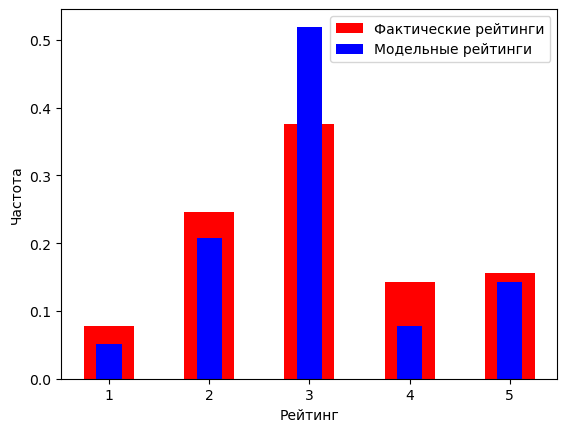

In [110]:
#Построение фактической и модельной диаграмм для модельного и экспертного рейтингов
plt.bar([1,2,3,4,5],graph_1,color='red',width=0.5);
plt.bar([1,2,3,4,5],graph_2,color='blue',width=0.25);
plt.legend(['Фактические рейтинги','Модельные рейтинги']);
plt.xlabel('Рейтинг', color='black')
plt.ylabel('Частота',color='black')